In [1]:
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from pandas import DataFrame
import xlsxwriter

ct_sheet = pd.ExcelFile("All CTSA 2-1yr No Interpolated Samples.xlsx") 

Using TensorFlow backend.


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(419, 148)
(419, 148)
Tensor("input_1:0", shape=(None, 148), dtype=float32)
Epoch 1/150
419/419 [==============================] - 1s 2ms/step - loss: 0.2117
Epoch 2/150
419/419 [==============================] - 0s 158us/step - loss: 0.1217
Epoch 3/150
419/419 [==============================] - 0s 148us/step - loss: 0.1011
Epoch 4/150
419/419 [==============================] - 0s 131us/step - loss: 0.0940
Epoch 5/150
419/419 [==============================] - 0s 148us/step - loss: 0.0900
Epoch 6/150
419/419 [==============================] - 0s 158us/step - loss: 0.0884
Epoch 7/150
419/419 [==============================] - 0s 148us/step - loss: 0.0855
Epoch 8/150
419/419 [==============================] - 0s 143us/step - loss: 0.0847
Epoch 9/150
419/419 [==============================] - 0s 124us/step - loss: 0.0832
Epoch 10/150
419/419 [==============================] - 0s 150us/step - loss: 0.0835
Epoch 11/150
419/419 [==============================] - 0s 128us/step - loss: 0.0832


419/419 [==============================] - 0s 150us/step - loss: 0.0734
Epoch 96/150
419/419 [==============================] - 0s 149us/step - loss: 0.0739
Epoch 97/150
419/419 [==============================] - 0s 137us/step - loss: 0.0731
Epoch 98/150
419/419 [==============================] - 0s 133us/step - loss: 0.0717
Epoch 99/150
419/419 [==============================] - 0s 153us/step - loss: 0.0727
Epoch 100/150
419/419 [==============================] - 0s 128us/step - loss: 0.0721
Epoch 101/150
419/419 [==============================] - 0s 146us/step - loss: 0.0728
Epoch 102/150
419/419 [==============================] - 0s 149us/step - loss: 0.0736
Epoch 103/150
419/419 [==============================] - 0s 159us/step - loss: 0.0729
Epoch 104/150
419/419 [==============================] - 0s 136us/step - loss: 0.0719
Epoch 105/150
419/419 [==============================] - 0s 122us/step - loss: 0.0715
Epoch 106/150
419/419 [==============================] - 0s 134us/step -

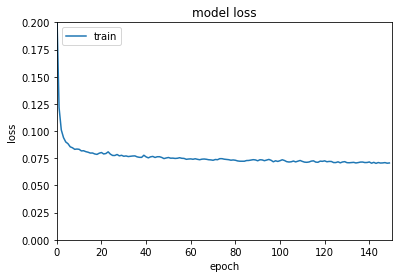

In [2]:
parsee = ct_sheet.sheet_names[0]
data = ct_sheet.parse(parsee)
data_features = data.loc[:, data.columns] 
data_features = data_features.drop(['ROI',11142,12142], axis=1)  

parsee2 = ct_sheet.sheet_names[1]
data2 = ct_sheet.parse(parsee2)
data_labels = data2.loc[:, data2.columns] 
data_labels = data_labels.drop(['ROI',11142,12142], axis=1)  
#Get rid of subject names to only have features now. #Need to remove ROIs. They don't convert to floats.
#Get rid of ctx_rh_Medial_wall and ctx_lh_Medial_wall, not needed for analysis.
scaler_filename = "IBIS_scaledCT1y.save"
scaler = joblib.load(scaler_filename)
scaled_data_1y = scaler.transform(data_features)

scaler_filename2 = "IBIS_scaledCT2y.save"
scaler2 = joblib.load(scaler_filename2)
scaled_data_2y = scaler.transform(data_labels)
print(scaled_data_1y.shape)
print(scaled_data_2y.shape)

#Size of encoded representation
#{'batch_size': 25, 'dropout': 0.15, 'encoded_layer_size': 15, 'epochs': 150, 'layer1_size': 90, 'layer2_size': 25}
input_size = 148
hidden_size = 90
hidden_size_2 = 25
encoding_dim = 15
dropout = 0.15

# Input Placeholder
input_data = Input(shape=(input_size,))
print(input_data)
# "encoded" is the encoded representation of the input
hidden_e_1 = Dense(hidden_size, activation='tanh')(input_data) 
hidden_e_2 = Dense(hidden_size_2, activation='tanh')(hidden_e_1)
dropout_layer = Dropout(dropout)(hidden_e_2)
encoded = Dense(encoding_dim, activation='tanh')(dropout_layer)
# "decoded" is the lossy reconstruction of the input
hidden_d_1 = Dense(hidden_size, activation='tanh')(encoded)
dropout_layer_d = Dropout(dropout)(hidden_d_1)
hidden_d_2 = Dense(hidden_size, activation='tanh')(dropout_layer_d)
decoded = Dense(input_size, activation='tanh')(hidden_d_2) 
# this model maps an input to its prediction
autoencoder = Model(input_data, decoded)
# configure our model to use mean_absolute_error loss function, and the Adam optimizer:
autoencoder.compile(optimizer='Adam', loss='mean_absolute_error')

ac = autoencoder.fit(scaled_data_1y, scaled_data_2y,
epochs=150,
batch_size=25,
shuffle=True)

#print(ac.history.keys())
# "Loss"
plt.plot(ac.history['loss'])
#plt.plot(ac.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, 150, 0.0, 0.2])
plt.show()

In [3]:
ct_sheet_1y = pd.ExcelFile("Data to be Interpolated.xlsx") 
parsee = ct_sheet_1y.sheet_names[1]
print(parsee)
data = ct_sheet_1y.parse(parsee)
data_features_ct1y = data.loc[:, data.columns] 
data_features_ct1y = data_features_ct1y.drop(['ROI',11142,12142], axis=1)
scaled_data_ct1y = scaler.transform(data_features_ct1y)
print(scaled_data_ct1y.shape)

predicted_2yr_ct = autoencoder.predict(scaled_data_ct1y)

1Y CT
(36, 148)


In [4]:
print(predicted_2yr_ct)

[[-0.21412036 -0.05441285  0.24003299 ... -0.11573028 -0.22023948
   0.1577718 ]
 [-0.27968124 -0.14757492  0.26261988 ... -0.16277531 -0.2855879
   0.16304646]
 [-0.24352756 -0.13540204  0.21065247 ... -0.15177552 -0.2673538
   0.13270624]
 ...
 [-0.2416731  -0.15509659  0.21084364 ... -0.14648707 -0.20295271
   0.1832456 ]
 [-0.27954176 -0.1629412   0.19449314 ... -0.16909803 -0.28337127
   0.12253852]
 [-0.24643084 -0.10105689  0.23877043 ... -0.14525181 -0.22536789
   0.16887492]]


In [5]:
df = pd.DataFrame(predicted_2yr_ct)
df.to_excel("Interpolated CT 2y.xlsx", index=False)

In [6]:
df

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,-0.214120,-0.054413,0.240033,0.131313,-0.175397,0.354141,0.219554,-0.092506,0.139230,0.087515,...,0.108878,0.338612,-0.077083,-0.012925,0.236654,0.290009,-0.282914,-0.115730,-0.220239,0.157772
1,-0.279681,-0.147575,0.262620,0.094089,-0.257105,0.311255,0.216934,-0.018049,0.182964,0.021448,...,0.054685,0.264690,-0.079196,0.003304,0.219771,0.205863,-0.274256,-0.162775,-0.285588,0.163046
2,-0.243528,-0.135402,0.210652,0.059955,-0.201491,0.313997,0.175814,-0.131312,0.084157,-0.004250,...,0.007682,0.203924,-0.108666,-0.036722,0.214969,0.237152,-0.313145,-0.151776,-0.267354,0.132706
3,-0.258278,-0.100701,0.268374,0.110117,-0.227410,0.311373,0.250771,-0.022897,0.181788,0.060469,...,0.090609,0.282868,-0.077010,-0.000782,0.227174,0.220974,-0.288309,-0.162466,-0.249728,0.166693
4,-0.246256,-0.201446,0.212069,0.074131,-0.218500,0.309769,0.151168,-0.152845,0.015947,-0.108402,...,0.010111,0.062495,-0.121503,-0.033023,0.192950,0.225295,-0.377803,-0.163817,-0.304243,0.121901
5,-0.199965,-0.021269,0.318744,0.175007,-0.162018,0.370085,0.285339,0.005233,0.183832,0.076002,...,0.170505,0.302564,-0.022246,0.025233,0.260478,0.275065,-0.271186,-0.120420,-0.199552,0.187999
6,-0.180027,-0.050405,0.257895,0.175779,-0.168315,0.352511,0.152508,-0.102485,0.090922,0.019707,...,0.087086,0.230780,-0.052294,0.018347,0.265227,0.285969,-0.276619,-0.080663,-0.210590,0.160754
7,-0.234102,-0.052782,0.264542,0.164561,-0.207983,0.320737,0.228322,-0.051703,0.156534,0.075986,...,0.131995,0.290482,-0.065160,0.003863,0.229262,0.245338,-0.296237,-0.147320,-0.227739,0.177446
8,-0.248765,-0.120388,0.228991,0.063095,-0.214666,0.316612,0.188353,-0.106804,0.131471,0.056124,...,0.059363,0.212074,-0.105844,-0.039624,0.217846,0.226730,-0.311284,-0.159758,-0.258295,0.128769
9,-0.237723,-0.143477,0.235611,0.076508,-0.205543,0.316243,0.194150,-0.109010,0.131831,0.022990,...,0.070528,0.177421,-0.089247,-0.013974,0.203449,0.242645,-0.313484,-0.155324,-0.232557,0.155420
